In [3]:
# coding=utf-8
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re

data_chat = pd.read_csv("../data/JDDC_100W训练数据集/训练数据集/chat.txt", sep = "\t", engine="python", 
                        warn_bad_lines = True, error_bad_lines = False, nrows = 1000, encoding = "UTF-8")
print(data_chat.shape)

(995, 7)


Skipping line 381: Expected 7 fields in line 381, saw 8
Skipping line 521: Expected 7 fields in line 521, saw 8
Skipping line 894: Expected 7 fields in line 894, saw 8
Skipping line 909: Expected 7 fields in line 909, saw 8
Skipping line 915: Expected 7 fields in line 915, saw 8


# 数据的输入输出

## 数据的几种存储格式
1. 最原始的数据是以.csv格式存储的，其中有session id和若干对话  
    使用`data_chat = pd.read_csv("../data/JDDC_100W训练数据集/训练数据集/chat_refined.txt", sep = "\t", engine="python",  warn_bad_lines = True, error_bad_lines = False, encoding = "UTF-8")`读取
2. 训练数据是以session的格式存储的
3. 处理过的数据存储的形式没有太大变化，依然是以.csv格式存储的，其中有session id和若干对话。我们所做的操作就是对于原始数据，替换特殊字符、数据清洗等一系列操作。


## 需要的函数
按照给的数据集，以.csv文件格式读入是最快的，所以数据的存储不妨还是按照.csv的格式  
只不过需要几个基本输入输出函数：
- output_session_clean()：把处理好的数据按照< QAQAQA >QQQQ的格式输出
- output_session_dirty(is_random)：将未合并的数据按照< QQAAQQQA >QQQQ的格式输出，同时利用is_random参数来控制session的生成（后期可以通过这种方法做data aggregation）
- output_csv()：把处理好的数据以.csv的格式输出，用pd.load_csv即可读入
- load_session_clean()：读入处理过的数据
- load_session_dirty()：读入未处理的数据（需要考虑格式和数据处理）

这样分了几个函数的目的是尽量减少读入数据的时间，因为按照session来组织的数据会读入得比较慢，load_session_dirty()时间消耗比较严重。  
所以在预处理时使用.csv格式处理数据，平时训练时尽可能用load_session_clean()来读入train set和dev set数据，使用load_session_dirty()读入测试集数据

## 评测数据的读入
load_session()不需要负责后续的数据处理工作，可以一起读完后处理。  
这样一个函数load_session_dirty()就可以了，

In [3]:
def output_session_clean(session_id, list_talk, f_output):
    f_output.write("<session " + session_id + ">\n")
    f_output.write("<context>\n")
    for i in range(len(list_talk)):
        if i < 3:
            if i & 1:
                f_output.write("Q:\t" + list_talk[i] + "\n")
            else :
                f_output.write("A:\t" + list_talk[i] + "\n")
        elif i == 3:
            f_output.write("</context>\n")
        else:
            f_output.write("<Q" + str(i-3) )

In [ ]:
def load_session_dirty(filepath):
    list_question = []
    list_answer = []
    with open(filepath) as f_in:
        ## 利用正则匹配读取session id
        line = f_in.readline()
        
        ## 读取QA
        while (True):
            line = 
            str_question = ""
            str_answer = ""
            if (line[0] == "<") break
            while (line[0] == "Q") str_question = str_question + " " + line[3:]
            while (line[0] == "A") str_answer = str_answer + " " + line[3:]
            list_question.append(str_question)
            list_answer.append(str_answer)
    return session_id, list_question, list_answer


load_session_dirty("../data/JDDC_评测用数据集/dev_question.txt")

## 最终输出给模型的格式
直接输出.csv文件即可

# 数据预处理
## 去除"\t"和其他无用字符
原来的数据虽然是用"\t"符号分隔开的，但是在chat中还是存在一些"\t"，需要处理一下，不然不能正确读入。  
下面的代码只需要运行一次：

```
with open("../data/JDDC_100W训练数据集/训练数据集/chat.txt", "r", encoding='UTF-8') as file_chat, open("../data/JDDC_100W训练数据集/训练数据集/chat_refined.txt", "w", encoding='UTF-8') as file_chat_refined:
    for line in file_chat:
        list_col = line.strip("\n").split("\t")
        line_temp = "\t".join(list_col[0:6])
        file_chat_refined.write(line_temp + "\t")
        line_talk = " ".join(list_col[6:]).strip()
        ## 去掉句子中的所有标点符号
#         line_talk = re.sub("['，','。','“','”','？','！','：','；','、',',','.','?','!','\"',':',';', '\0']", " ", line_talk)
        ## 去掉句子中的'\"'等几个符号，其余都传到seq2seq里
        line_talk = re.sub("['\"', '\0', '&nbsp']", " ", line_talk)
#         print(line_talk)
        file_chat_refined.write(line_talk + "\n")
    file_chat_refined.flush()
    os.fsync(file_chat_refined.fileno())
```

In [7]:
    def get_file_removed_tab(n_col, col_index, filepath_origin, filepath_refined):
        """
        There may be \t in the col containing long texts.
        So that this file cannot be loaded as .csv file

        This funtion is to remove unexpected tabs in texts.
        Please make sure here's only one col that contains unexpected tabs.

        Args:
            n_col : total number of columns.
            col_index : the index of the col that contains unexpected tabs.
                index is start from 1.

        Note: col_index is start from 1 !!
        """
        if os.path.exists(filepath_refined):
            print("The file after removing unexpected tabs exists.")
            return
        with open(filepath_origin, "r", encoding='UTF-8') as file_in, open(
                filepath_refined, "w", encoding='UTF-8') as file_out:
            if n_col == 0:
                return
            for line in file_in:
                list_col = line.strip("\n").split("\t")
                str_tmp1 = "\t".join(list_col[0:col_index-1])

                if n_col != col_index:
                    str_given_col = " ".join(list_col[col_index - 1:-(n_col - col_index)]).strip()
                    str_given_col = re.sub("['\"', '\0', '&nbsp']", " ", str_given_col)
                    str_tmp2 = "\t".join(list_col[-(n_col-col_index):])
                    str_res = "\t".join([str_tmp1, str_given_col, str_tmp2])
                else :
                    str_given_col = " ".join(list_col[col_index - 1:]).strip()
                    str_given_col = re.sub("['\"', '\0', '&nbsp']", " ", str_given_col)
                    str_res = "\t".join([str_tmp1, str_given_col])
                file_out.write(str_res + "\n")
            file_out.flush()
            os.fsync(file_out.fileno())
        print("output file after removing unexpected tab.")
        
get_file_removed_tab(7, 7, "../data/JDDC_100W训练数据集/训练数据集/chat.txt", 
           "../data/JDDC_100W训练数据集/训练数据集/chat_refined.txt")

output file after removing unexpected tab.


In [2]:
data_chat = pd.read_csv("../data/JDDC_100W训练数据集/训练数据集/chat_refined.txt", sep = "\t", engine="python", 
                        warn_bad_lines = True, error_bad_lines = False, nrows = 1000, encoding = "UTF-8")
print(data_chat.shape)
print(data_chat.head)

(1000, 7)
<bound method NDFrame.head of                                  会话编号             顾客id  sku  是否客服发送  是否转出  \
0    000002d0fa6d23510c40200e45ce293c  USERID_10503190    0       0     0   
1    000002d0fa6d23510c40200e45ce293c  USERID_10503190    0       0     0   
2    000002d0fa6d23510c40200e45ce293c  USERID_10503190    1       0     0   
3    000002d0fa6d23510c40200e45ce293c  USERID_10503190    1       0     0   
4    000002d0fa6d23510c40200e45ce293c  USERID_10503190    1       0     0   
5    000002d0fa6d23510c40200e45ce293c  USERID_10503190    0       0     0   
6    000002d0fa6d23510c40200e45ce293c  USERID_10503190    1       0     0   
7    000002d0fa6d23510c40200e45ce293c  USERID_10503190    1       0     0   
8    000002d0fa6d23510c40200e45ce293c  USERID_10503190    1       0     0   
9    000002d0fa6d23510c40200e45ce293c  USERID_10503190    0       0     0   
10   000002d0fa6d23510c40200e45ce293c  USERID_10503190    1       0     0   
11   000002d0fa6d23510c40200e45ce293

### 去除具有nan的行

In [ ]:
n_row = data_chat.shape[0]
print(n_row)

# print(data_chat[[2]].notnull())
bool_list = np.array(data_chat[[2]].notnull()).astype("bool")

data_chat = data_chat[np.array(data_chat[[2]].notnull()).astype("bool")]
n_row = data_chat.shape[0]
print(n_row)
data_chat = data_chat[data_chat[[3]].notnull()]
n_row = data_chat.shape[0]
print(n_row)
data_chat = data_chat[data_chat[[4]].notnull()]
n_row = data_chat.shape[0]
print(n_row)

## 读取处理好的数据
访问data_chat的数据的步骤：
1. 先利用session_index获取到index: index = x_session_ptr[session_index]
2. 在通过.iat确定访问第i列

### 已经处理好的文件
1. 可以正常读入的数据："../data/JDDC_100W训练数据集/训练数据集/chat_refined.txt"
2. 替换特殊字段的数据："../data/JDDC_100W训练数据集/训练数据集/chat_refined1.txt"
3. 合并多个Q的，随机取1W条 "../data/JDDC_100W训练数据集/训练数据集/chat_refined2.txt"

In [4]:
data_chat = pd.read_csv("../data/chat_primary.txt", sep = "\t", engine="python", 
                        warn_bad_lines = True, error_bad_lines = False, encoding = "UTF-8", header = None)

n_row = data_chat.shape[0]
print(n_row)

20562030


# EDA

In [5]:
set_session = set()
set_user = set()

## 对于每个session，我们统计两个量length和ptr
## length是每个session对话的长度，ptr是每个对话在data中的起始位置。
x_session_length = np.zeros((2000000,), dtype = "int")
x_session_ptr = np.zeros((2000000,), dtype = "int")
cnt_session = 0 

max_session_length = -1
max_user_id = -1
max_session_id = -1
max_session_index = -1

for i in range(n_row):
    if not data_chat.iat[i, 0] in set_session:
        if i != 0:
            x_session_length[cnt_session] = cnt_session_length
            cnt_session += 1
        x_session_ptr[cnt_session] = i
        cnt_session_length = 1
        set_session.add(data_chat.iat[i, 0])
        set_user.add(data_chat.iat[i, 1])
    else:
        cnt_session_length += 1
        if cnt_session_length > max_session_length:
            max_session_length = cnt_session_length
            max_user_id = data_chat.iat[i, 1]
            max_session_id = data_chat.iat[i, 0]
            max_session_index = cnt_session
x_session_length[cnt_session] = cnt_session_length
x_session_ptr[cnt_session+1] = n_row

x_session_length = x_session_length[0:cnt_session+1]
x_session_ptr = x_session_ptr[0:cnt_session+2]

print(len(set_session), len(set_user))
print(max_session_index, max_user_id, max_session_id, max_session_length)

## 访问data_chat的数据的步骤：
## 1. 先利用session_index获取到index: index = x_session_ptr[session_index]
## 2. 在通过.iat确定访问第i列
print(data_chat.iat[x_session_ptr[max_session_index], 0])
print(data_chat.iat[x_session_ptr[cnt_session], 0])

1025141 881928
461193 USERID_10661921 733126348eb62736d7d7503739b30005 314
733126348eb62736d7d7503739b30005
ffffebe3c1d538897ea15f1ead8f3fff


## 统计会话数、客户数和会话长短分布

先看看length的变化趋势

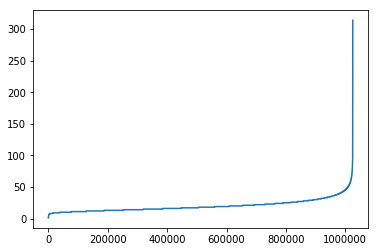

In [29]:
plt.plot(range(0, cnt_session), np.sort(x_session_length))
plt.show()

看看length的分布

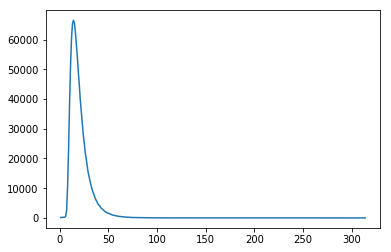

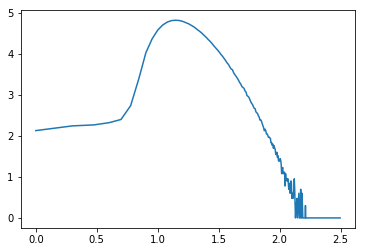

In [39]:
from collections import Counter
dict_session_length = Counter(np.sort(x_session_length))
# print(dict_session_length)

X = np.array(list(dict_session_length.keys())).reshape(-1, 1)  # numbers of one same feature value
Y = np.array(list(dict_session_length.values())).reshape(-1, 1) # count

plt.plot(X, Y)
plt.show()

X = np.log10(np.array(list(dict_session_length.keys()))).reshape(-1, 1)  # numbers of one same feature value
Y = np.log10(list(dict_session_length.values())).reshape(-1, 1) # count

plt.plot(X, Y)
plt.show()

通过绘制session_length的分布，可以发现是偏向于正态分布的，大多数数据集中在0-50范围内。  
通过绘制箱型图再确认一下。

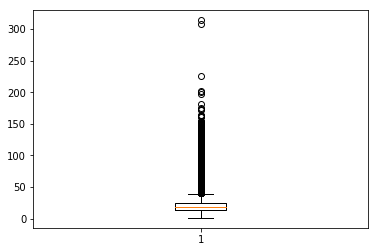

In [25]:
plt.boxplot(x_session_length)
plt.show()

Q：那么离群的数量有多少呢？如何确定异常点的分割呢？  
A：soft oulier有45737，过多，`1.5 * IQR`不宜直接作为异常点的分割。通过多次测试，选择`outlier_step = 5 * IQR`作为异常点的分割。

In [10]:
## Q1为数据占25%的数据值范围
Q1 = np.percentile(x_session_length, 25)

## Q3为数据占75%的数据范围
Q3 = np.percentile(x_session_length, 75)
IQR = Q3 - Q1

## 正常值的范围
outlier_step = 0.1 * IQR
list_standard = [x for x in x_session_length if x < Q3 + outlier_step or x > Q1 - outlier_step]

# print(Q3 + outlier_step, Q1 - outlier_step)

print(len(list_standard))

## soft 异常值的范围
outlier_step = 1.5 * IQR
list_outlier = [x for x in x_session_length if x > Q3 + outlier_step or x < Q1 - outlier_step]

print(Q3 + outlier_step, Q1 - outlier_step)

print(len(list_outlier))

## hard 异常值的范围
## 这个hard异常值是测试得到的，发现3 * IQR有1w+异常值，但5 * IQR，比较合适
outlier_step = 5 * IQR
list_outlier = [x for x in x_session_length if x > Q3 + outlier_step or x < Q1 - outlier_step]

print(Q3 + outlier_step, Q1 - outlier_step)

print(len(list_outlier))

1025172
39.0 -1.0
45737
74.0 -36.0
2184


输出前10长的异常对话，观察特点：
1. 存在大量重复内容
2. 存在大量未合并内容

In [34]:
## 找到length对应的session index
x_session_length_argsort = np.argsort(x_session_length)
print(x_session_length[x_session_length_argsort[-1]]) ## 应该为314
print(x_session_length_argsort[-1]) ## 应该为461218
print(x_session_ptr[x_session_length_argsort[-1]]) ## 应该为9242002

## 输出前10个异常对话，观察特点
for i in range(1, 11):
    print()
    ptr_now = x_session_ptr[x_session_length_argsort[-i]]
    ptr_end = x_session_ptr[x_session_length_argsort[-i] + 1] ## 最后一个对话不是异常的，所以不会out of index
    print("i == " + str(i), ptr_end-ptr_now)
    print()
    while (ptr_now < ptr_end):
        print(int(data_chat.iat[ptr_now, 2]), data_chat.iat[ptr_now, 6])
        ptr_now += 1
    

314
461218
9242002

i == 1 314

0 https //item jd com/4669576 html
0 https //item jd com/4669576 html
0 [数字x]n[数字x] 手机蓝屏
1 有什么问题我可以帮您处理或解决呢 
0 https //item jd com/4669576 html
0 https //item jd com/4669576 html
0 https //item jd com/4669576 html
0 无法重启
0 https //item jd com/4669576 html
1 亲爱的 您能提供下订单号吗
1 妹子帮您查询那
0 https //item jd com/4669576 html
0 [ORDERID_10004169]
0 https //item jd com/4669576 html
0 https //item jd com/4669576 html
1 还请您稍等 马上为您查询~
0 https //item jd com/4669576 html
0 https //item jd com/4669576 html
1 亲爱的 妹子帮您申请售后维修可以吗#E-s[数字x]
0 现在直接无法开机了
0 怎么维修啊
1 就是帮您申请售后维修
0 https //item jd com/4669576 html
0 嗯
0 https //item jd com/4669576 html
0 https //item jd com/4669576 html
0 可以
0 https //item jd com/4669576 html
1 已经帮您申请了哈
0 https //item jd com/4669576 html
1 请您等待售后联系哈
0 我在 在线等吗
1 亲爱的 不需要的哈
1 需要售后审核的哈
0 现在无法接听电话了
0 https //item jd com/4669576 html
0 那我啥时候等结果
1 亲爱的 今天会审核的哈
0 你们怎么 联系我啊
0 https //item jd com/4669576 html
0 https //item jd com/4669576 html
1 嗯呐
0 https //ite

1 还请您耐心等待一下
1 也请您放心
1 再咱们京东购买的商品
0 好的非常感谢
1 咱们都是具有售后保障的
0 是的 还会在京东上买
1 您客气啦
0 不过我不会买海尔了 
1 #E-s[数字x]感谢您的支持哟
1 也请您放心  咱们京东提供的也不止是质的保证哟
1 还有心的服务
1 #E-s[数字x]
0 #E-s[数字x]#E-s[数字x]
1 已经帮您申请好啦】
0 这么迅速 赞 
1 这边[数字x]点前就会为您审核呢
0 现在我要怎么做 
1 还需要您耐心等待一下审核结果呢
1 小的这边只是为您递交了服务单呢
1 #E-s[数字x]#E-s[数字x]
0 哦哦 冰箱还是先放在快递小哥那边吧 还是让他送回来啊 
0 哦哦
1 是这样的呢亲
1 小的给您查看到
1 咱们之前申请的服务单还未取消呢
0 那我这边显示已经取消了
0 等等
1 小的这边建议您前台取消一下呢
1 嗯嗯
0 我再看下
1 您查看核实一下
1 这样会有冲突呢
0 所以我这边全部取消是吧
1 咱们这边[姓名x]的空调
1 也提交了服务单呢
0 你帮我看下你说没有取消的 申请日期是什么时候
1 咱们服务单上是填写的客户发货呢
1 您九点申请的呢
0 嗯 我再取消 没有办法选择啊 不是我写的客户发货 是他就没得选择
0 现在取消了
1 还请您取消一下 小的帮您核实一下呢
0 嗯嗯
0 已经取消了
1 小的之前误操了呢 很抱歉 未能给您递交上去
1 好的
0 嗯嗯谢谢美女 
1 您看尾号[数字x]
1 方便提供一下验证码么 
0 [数字x]
1 嗯嗯
1 感谢您的信任哈
1 #E-s[数字x]#E-s[数字x]
0 谢谢您的帮忙 
1 NINKEQI LA
0  
1 亲亲
1 小的这边帮您多次尝试申请
0 哦哦 我等#E-抱拳
1 咱们的商品 确实联系不了上门取件服务呢
1 #E-s[数字x]
0 为什么呢 不是京东物流配送的吗 
1 都是需要咱们 自行发货至售后
0 [姓名x]都可以 而且人家行动迅
1 是的呢 因为咱们这边
0 所以这个我不同意啊 我要求必须上门来取货啊 
1 [姓名x]是属于咱们第三方合作的商家
0 同样是在京东上买的 为什么还有 不能上门来取货 [姓名x]都很快就来取走了
1 不是咱们京东自营呢
1 咱们返还货物是返还给他们商家
0 这个是你们京东跟[姓名x]的事情 我

## 对Q和A中的句子进行聚类
将看看哪些句子具有代表性，看能不能用模板化句子代替  
对于Q和A两部分分别进行聚类

# 数据清洗
直接在原来的dataframe上逐行处理，然后输出成新文件

## 替换特殊字段
特殊字段有：
1. #E-s[数字x] #E-2[数字x] 等一系列数字—— 表情
2. [ORDERID_10187709] —— 订单号
3. [数字x] —— 数字
4. https://item.jd.com/5898522.html —— 网址
5. [地址x] —— 地址
6. [链接x] —— 链接
7. [金额x] —— 金额
8. [日期x] —— 日期
9. [时间x] —— 时间
10. [站点x] —— 站点
11. [组织机构x] ——组织机构
12. [电话x] —— 电话
13. [姓名x] —— 人名


其中重灾区为[姓名x]，存在很多[姓名x]字段不是人名的问题。

~~对于表情，做法是直接删除。~~  其他用希腊符号替换。

In [20]:
## 输出文件

with open("../data/JDDC_100W训练数据集/训练数据集/chat_refined2.txt", "w", encoding='UTF-8') as f_out:
    for i in range(len(data_chat)):
        if pd.isnull(data_chat.iat[i, 2]) or pd.isnull(data_chat.iat[i, 3]) or pd.isnull(data_chat.iat[i, 4]): continue
        
        str_talk = str(data_chat.iat[i, 6])
        str_talk = re.sub("#E\-[\w]*(抱拳|傲慢|得意|蛋糕|呕吐|闭嘴|礼物|yaoping|柠檬|流泪|怒火|撇嘴|太阳|咒骂|糗|猪猪|足球|磕头|大兵|电话|灯泡|飞鸟|奋斗|高兴|击打|饥饿|咖啡|口罩|骷髅|可乐|疯狂|白眼|阴险|叹气|奸笑|发呆|害羞|飞吻|怒火|悲伤|胜利|生病|弱|可怜|咖啡|酷酷|眩晕|流泪|发抖|难过|右哼哼|惊恐|悲伤|犯困|愤怒|凋谢|哈欠|拥抱|抓狂|鄙视|时间|啤酒|勾引|左哼哼|月亮|偷笑|震惊|惊讶|跳跳|瞌睡|可爱|衰样|好|憨笑|水果|色色|黑线|微笑|流汗|握手|心碎|问号|大哭|亲亲|抠鼻|拜拜|鬼脸|香吻|米饭|花朵|尴尬|擦汗|安慰|委屈|调皮|爱心|我一定尽力为您解答的哦|很棒|鼓掌)+", "α", str_talk) ## 匹配 #E-流汗
        str_talk = re.sub("#E\-[\w]+\[数字x]", "α", str_talk)
        str_talk = re.sub("\[ORDERID_[\d]+]", "β", str_talk)
        str_talk = re.sub("\[数字x]", "γ", str_talk)
        str_talk = re.sub("\[地址x]", "δ", str_talk)
        str_talk = re.sub("\[链接x]", "ε", str_talk)
        str_talk = re.sub("\[金额x]", "ζ", str_talk)
        str_talk = re.sub("\[日期x]", "θ", str_talk)
        str_talk = re.sub("\[时间x]", "κ", str_talk)
        str_talk = re.sub("\[站点x]", "λ", str_talk)
        str_talk = re.sub("\[组织机构x]", "μ", str_talk)
        str_talk = re.sub("\[电话x]", "ν", str_talk)
        str_talk = re.sub("\[姓名x]", "ξ", str_talk)
        str_talk = re.sub("\[邮箱x]", "π", str_talk)
        str_talk = re.sub("\[身份证号x]", "ρ", str_talk)
        str_talk = re.sub("\[商品快照]", "σ", str_talk)
        str_talk = re.sub("\[表情]", "α", str_talk)
        str_talk = re.sub("(http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", "ε", str_talk)
        str_talk = re.sub("(http|ftp|https):\/\/ε", "ε", str_talk)
        str_talk = re.sub("[\d]+.*[\d]+", "γ", str_talk)
        str_talk = re.sub("【收到不支持的消息类型，暂无法显示】", " ", str_talk)
        
        str_talk = re.sub("#E\-[s]*(ν|γ|π|ζ|ρ|α|ε)*", "α", str_talk)
        str_talk = re.sub("α", " ", str_talk)
        
        if str_talk.strip() != "":
            f_out.write(str(data_chat.iat[i, 0]) + "\t" + str(data_chat.iat[i, 1]) + "\t" + str(data_chat.iat[i, 2]) + 
                        "\t" + str(data_chat.iat[i, 3]) + "\t" + str(data_chat.iat[i, 4]) + "\t" + str(data_chat.iat[i, 5]) + 
                        "\t" + str_talk + "\n")
        else :
            continue
    print("ouput finish")

ouput finish


## 合并句子
~~将具有QQQAAA性质的多个句子合并成QA两个句子~~  
~~在代码loader中实现，不需要预处理~~

合并多个Q的，1W条

In [13]:
import random
with open("../data/JDDC_100W训练数据集/训练数据集/chat_1per.txt", "w", encoding='UTF-8') as f_out:
    for i in range(cnt_session+1):
        if random.uniform(0, 1) <= 0.01:
            sentence = ""
            is_first = True
            for j in range(x_session_ptr[i], x_session_ptr[i+1]):
                ## 保证是QAQA的形式，而不是AQAQAQ
                
                if is_first and (data_chat.iat[j, 2] == "1"):
                    continue
                is_first = False
                ## 如果QQQAQA的第一个Q那么先输出这一行的0-5列，再存储句子
                ## 如果是中继的QQ，则加上
                ## 如果是末尾的，则输出sentence，并重置
                
                ## 如果是QA的Q，则直接输出行
                
                ## 对于下一个不存在的情况，根据sentence是否存在看是输出sentence或是整行
                
                if sentence == "" and j + 1 < x_session_ptr[i+1] and data_chat.iat[j, 2] == data_chat.iat[j+1, 2]:
                    f_out.write(str(data_chat.iat[j, 0]) + "\t" + str(data_chat.iat[j, 1]) + "\t" + str(data_chat.iat[j, 2]) 
                                + "\t" + str(data_chat.iat[j, 3]) + "\t" + str(data_chat.iat[j, 4]) + "\t" + str(data_chat.iat[j, 5]) 
                                + "\t")
                    sentence += data_chat.iat[j, 6]
                elif sentence != "" and j + 1 < x_session_ptr[i+1] and data_chat.iat[j, 2] == data_chat.iat[j+1, 2]:
                    sentence += " " + data_chat.iat[j, 6]
                elif sentence != "" and j + 1 < x_session_ptr[i+1] and data_chat.iat[j, 2] != data_chat.iat[j+1, 2]:
                    f_out.write(sentence + "\n")
                    sentence = ""
                elif sentence == "" and j + 1 < x_session_ptr[i+1] and data_chat.iat[j, 2] != data_chat.iat[j+1, 2]:
                    f_out.write(str(data_chat.iat[j, 0]) + "\t" + str(data_chat.iat[j, 1]) + "\t" + str(data_chat.iat[j, 2]) 
                               + "\t" + str(data_chat.iat[j, 3]) + "\t" + str(data_chat.iat[j, 4]) + "\t" + str(data_chat.iat[j, 5]) 
                               + "\t" + data_chat.iat[j, 6] + "\n")
                elif sentence == "" and j + 1 == x_session_ptr[i+1]:
                    f_out.write(str(data_chat.iat[j, 0]) + "\t" + str(data_chat.iat[j, 1]) + "\t" + str(data_chat.iat[j, 2]) 
                               + "\t" + str(data_chat.iat[j, 3]) + "\t" + str(data_chat.iat[j, 4]) + "\t" + str(data_chat.iat[j, 5]) 
                               + "\t" + data_chat.iat[j, 6] + "\n")
                elif sentence != "" and j + 1 == x_session_ptr[i+1]:
                    f_out.write(sentence + "\n")
                    sentence = ""
        else :
            continue

skip 25901
skip 25902
skip 28938
skip 28939
skip 33115
skip 33116
skip 38238
skip 45793
skip 45794
skip 46445
skip 48599
skip 69004
skip 72264
skip 73207
skip 76170
skip 78281
skip 84778
skip 90062
skip 90063
skip 90064
skip 98252
skip 109992
skip 137757
skip 168350
skip 171958
skip 172782
skip 181528
skip 186029
skip 190195
skip 195259
skip 195336
skip 196916
skip 206200
skip 208117
skip 223396
skip 232742
skip 244763
skip 246485
skip 249073
skip 252486
skip 259282
skip 262757
skip 265756
skip 293230
skip 293231
skip 294229
skip 325006
skip 340209
skip 340210
skip 347149
skip 348154
skip 348155
skip 363571
skip 363572
skip 375791
skip 381033
skip 409256
skip 432121
skip 443170
skip 467713
skip 470722
skip 472085
skip 506650
skip 506651
skip 506953
skip 506954
skip 509901
skip 511984
skip 523928
skip 538617
skip 538618
skip 550659
skip 550660
skip 556604
skip 556605
skip 558582
skip 560317
skip 568326
skip 575502
skip 577750
skip 579307
skip 584881
skip 594710
skip 594711
skip 599951
s

skip 5100554
skip 5100555
skip 5128345
skip 5132381
skip 5164533
skip 5165210
skip 5177004
skip 5200744
skip 5200745
skip 5207264
skip 5209863
skip 5217378
skip 5224889
skip 5239275
skip 5240792
skip 5273153
skip 5273405
skip 5273406
skip 5294514
skip 5318254
skip 5322263
skip 5325346
skip 5328110
skip 5333700
skip 5352379
skip 5360733
skip 5377306
skip 5384188
skip 5388652
skip 5396049
skip 5408082
skip 5410499
skip 5410500
skip 5417713
skip 5417714
skip 5429736
skip 5430763
skip 5430855
skip 5435118
skip 5435119
skip 5435120
skip 5440003
skip 5440004
skip 5440147
skip 5449262
skip 5460837
skip 5471559
skip 5483129
skip 5485230
skip 5486895
skip 5491220
skip 5499910
skip 5504914
skip 5537136
skip 5538094
skip 5538095
skip 5538096
skip 5539724
skip 5541954
skip 5549706
skip 5552153
skip 5565551
skip 5565552
skip 5568452
skip 5590138
skip 5593545
skip 5595180
skip 5603584
skip 5605112
skip 5610079
skip 5651025
skip 5651826
skip 5659380
skip 5660827
skip 5661449
skip 5661450
skip 5661451

skip 12558579
skip 12558580
skip 12566004
skip 12570100
skip 12572489
skip 12575442
skip 12578236
skip 12582281
skip 12582282
skip 12582637
skip 12592170
skip 12592171
skip 12603022
skip 12609894
skip 12626693
skip 12626694
skip 12627144
skip 12634200
skip 12634201
skip 12634202
skip 12634203
skip 12636707
skip 12636708
skip 12636709
skip 12644995
skip 12646003
skip 12657676
skip 12657677
skip 12657678
skip 12661086
skip 12663312
skip 12664752
skip 12682499
skip 12682500
skip 12683880
skip 12692939
skip 12695222
skip 12708277
skip 12709086
skip 12710437
skip 12712794
skip 12722370
skip 12729541
skip 12751622
skip 12761142
skip 12761143
skip 12772897
skip 12794298
skip 12799914
skip 12802851
skip 12802852
skip 12803765
skip 12804870
skip 12805407
skip 12825629
skip 12830401
skip 12832116
skip 12832117
skip 12861208
skip 12864137
skip 12872258
skip 12889774
skip 12909650
skip 12913906
skip 12921343
skip 12921344
skip 12927510
skip 12934223
skip 12934842
skip 12934843
skip 12939034
skip 1

skip 18676898
skip 18686490
skip 18691800
skip 18710877
skip 18734876
skip 18738162
skip 18742975
skip 18748316
skip 18748317
skip 18765343
skip 18772985
skip 18774519
skip 18774520
skip 18774521
skip 18775430
skip 18787407
skip 18806352
skip 18812674
skip 18853955
skip 18869973
skip 18871961
skip 18877009
skip 18890260
skip 18915146
skip 18939801
skip 18945607
skip 18945608
skip 18948618
skip 18948619
skip 18948620
skip 18960043
skip 19002479
skip 19013904
skip 19027296
skip 19028214
skip 19028273
skip 19037123
skip 19037124
skip 19063953
skip 19072816
skip 19072817
skip 19074252
skip 19089353
skip 19089354
skip 19090393
skip 19132873
skip 19140964
skip 19144984
skip 19167999
skip 19184797
skip 19224879
skip 19233236
skip 19239604
skip 19239793
skip 19240582
skip 19240583
skip 19240584
skip 19243870
skip 19263862
skip 19270717
skip 19270718
skip 19276569
skip 19286818
skip 19286819
skip 19299621
skip 19326650
skip 19339829
skip 19339830
skip 19359493
skip 19360812
skip 19368157
skip 1

## 包含上下文的Q文件
第一步：我们要输出的是一个session对应的一个(context, q)二元组，换言之，对于每一个session，只用前3个生成。  
第二步：在后续实验中，可以多生成一点。

In [15]:
with open("../data/JDDC_100W训练数据集/训练数据集/chat_1per with context.txt", "w", encoding='UTF-8') as f_out:
    for i in range(cnt_session+1):
        ## session长度不够
        if x_session_ptr[i+1] - x_session_ptr[i] <= 7:
            continue
 
        cnt = 0
        text = ""
        for j in range(x_session_ptr[i], x_session_ptr[i+1]):
            if (j == x_session_ptr[i] and data_chat.iat[j, 2] == 1):
                continue
            if (cnt >= 7) :
                break
            text += data_chat.iat[j, 6] + " "
            cnt += 1
#         f_out.write(str(data_chat.iat[x_session_ptr[i], 0]) + "\t" + str(data_chat.iat[x_session_ptr[i], 1]) + "\t" + 
#                     str(data_chat.iat[x_session_ptr[i], 2]) + "\t" + text + "\n")
        if data_chat.iat[x_session_ptr[i], 2] == 0:
            f_out.write(text + "\n" + data_chat.iat[x_session_ptr[i]+7, 6] + "\n")
        else :
            f_out.write(text + "\n" + data_chat.iat[x_session_ptr[i]+8, 6] + "\n")

## 将同一长句中的相似内容合并
两个句子的相似度通过余弦相似度衡量

In [39]:
import jieba

def get_word_vector(s1,s2):
    """
    :param s1: 句子1
    :param s2: 句子2
    :return: 返回句子的余弦相似度
    """
    # 分词
    cut1 = jieba.cut(s1)
    cut2 = jieba.cut(s2)
    list_word1 = (','.join(cut1)).split(',')
    list_word2 = (','.join(cut2)).split(',')

    # 列出所有的词,取并集
    key_word = list(set(list_word1 + list_word2))
    # 给定形状和类型的用0填充的矩阵存储向量
    word_vector1 = np.zeros(len(key_word))
    word_vector2 = np.zeros(len(key_word))

    # 计算词频
    # 依次确定向量的每个位置的值
    for i in range(len(key_word)):
        # 遍历key_word中每个词在句子中的出现次数
        for j in range(len(list_word1)):
            if key_word[i] == list_word1[j]:
                word_vector1[i] += 1
        for k in range(len(list_word2)):
            if key_word[i] == list_word2[k]:
                word_vector2[i] += 1

    # 输出向量
    print(word_vector1)
    print(word_vector2)
    return word_vector1, word_vector2



def cos_dist(vec1,vec2):
    """
    :param vec1: 向量1
    :param vec2: 向量2
    :return: 返回两个向量的余弦相似度
    """
    dist1=float(np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
    return dist1

## test内容 结果应该是0.8164965809277261
# s1="很高兴见到你"
# s2="我也很高兴见到你"
# vec1,vec2=get_word_vector(s1,s2)
# dist1=cos_dist(vec1,vec2)
# print(dist1)

[0. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1.]
0.8164965809277261


In [2]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import jieba
import re

smooth = SmoothingFunction()

reference=['The', 'new', 'translator', 'will', 'stand', 'on', 'the', 'exhibition', 'on', 'behalf', 'of', 'the', 'four', 'times', 'group', 'at', 'the', 'exhibition', 'We', 'will', 'introduce', 'the', 'new', 'star`s', 'business', 'the', 'advantages', 'and', 'the', 'successful', 'cases', 'so', 'that', 'you', 'can', 'understand', 'the', 'new', 'translator', 'more', 'comprehensively', 'We', 'have', 'a', 'stable', 'full-time', 'international', 'team', 'that', 'ensures', 'punctual', 'efficient', 'translation', 'and', 'dubbing', 'and', 'provides', 'a', 'full', 'range', 'of', 'control', 'through', 'the', 'perfect', 'quality', 'control', 'and', 'project', 'management', 'system', 'providing', 'a', 'one-stop', 'service', 'for', 'translation', 'dubbing', 'subtitle', 'production', 'post', 'production', 'broadcasting', 'and', 'ratings', 'surveys'],['The', 'new', 'translator', 'star', 'will', 'represent', 'sida', 'times', 'group', 'in', 'the', 'exhibition', 'when', 'we', 'will', 'introduce', 'the', 'new', 'translator', 'star`s', 'business', 'advantages', 'successful', 'cases', 'and', 'other', 'dimensions', 'so', 'that', 'you', 'can', 'have', 'a', 'more', 'comprehensive', 'understanding', 'of', 'the', 'new', 'translator', 'star', 'We', 'have', 'a', 'stable', 'full-time', 'international', 'team', 'which', 'can', 'ensure', 'timely', 'and', 'efficient', 'translation', 'and', 'dubbing', 'Through', 'perfect', 'quality', 'control', 'and', 'project', 'management', 'system', 'we', 'provide', 'translation', 'dubbing', 'subtitle', 'production', 'post-production', 'broadcasting', 'and', 'rating', 'survey']
candidate_baidu=['New', 'Transtar', 'will', 'stand', 'on', 'the', 'exhibition', 'on', 'behalf', 'of', 'the', 'four', 'times', 'group', 'at', 'the', 'exhibition', 'We', 'will', 'introduce', 'the', 'new', 'star`s', 'business', 'the', 'advantages', 'and', 'the', 'successful', 'cases', 'so', 'that', 'you', 'can', 'understand', 'the', 'new', 'translator', 'more', 'comprehensively', 'We', 'have', 'a', 'stable', 'full-time', 'international', 'team', 'that', 'ensures', 'punctual', 'efficient', 'translation', 'and', 'dubbing', 'and', 'provides', 'a', 'full', 'range', 'of', 'control', 'through', 'the', 'perfect', 'quality', 'control', 'and', 'project', 'management', 'system', 'providing', 'a', 'one-stop', 'service', 'for', 'translation', 'dubbing', 'subtitle', 'production', 'streamlined', 'and', 'developed', 'quality', 'control', 'and', 'project', 'management', 'system']
n_eval = sentence_bleu(reference, candidate_baidu, smoothing_function=smooth.method1)
print(n_eval)

reference=[['The', 'new', 'translator', 'will', 'stand', 'on', 'the', 'exhibition', 'on', 'behalf', 'of', 'the', 'four', 'times', 'group', 'at', 'the', 'exhibition', 'We', 'will', 'introduce', 'the', 'new', 'star`s', 'business', 'the', 'advantages', 'and', 'the', 'successful', 'cases', 'so', 'that', 'you', 'can', 'understand', 'the', 'new', 'translator', 'more', 'comprehensively', 'We', 'have', 'a', 'stable', 'full-time', 'international', 'team', 'that', 'ensures', 'punctual', 'efficient', 'translation', 'and', 'dubbing', 'and', 'provides', 'a', 'full', 'range', 'of', 'control', 'through', 'the', 'perfect', 'quality', 'control', 'and', 'project', 'management', 'system', 'providing', 'a', 'one-stop', 'service', 'for', 'translation', 'dubbing', 'subtitle', 'production', 'post', 'production', 'broadcasting', 'and', 'ratings', 'surveys'],['The', 'new', 'translator', 'star', 'will', 'represent', 'sida', 'times', 'group', 'in', 'the', 'exhibition', 'when', 'we', 'will', 'introduce', 'the', 'new', 'translator', 'star`s', 'business', 'advantages', 'successful', 'cases', 'and', 'other', 'dimensions', 'so', 'that', 'you', 'can', 'have', 'a', 'more', 'comprehensive', 'understanding', 'of', 'the', 'new', 'translator', 'star', 'We', 'have', 'a', 'stable', 'full-time', 'international', 'team', 'which', 'can', 'ensure', 'timely', 'and', 'efficient', 'translation', 'and', 'dubbing', 'Through', 'perfect', 'quality', 'control', 'and', 'project', 'management', 'system', 'we', 'provide', 'translation', 'dubbing', 'subtitle', 'production', 'post-production', 'broadcasting', 'and', 'rating', 'survey']]
candidate_baidu=['New', 'Transtar', 'will', 'stand', 'on', 'the', 'exhibition', 'on', 'behalf', 'of', 'the', 'four', 'times', 'group', 'at', 'the', 'exhibition', 'We', 'will', 'introduce', 'the', 'new', 'star`s', 'business', 'the', 'advantages', 'and', 'the', 'successful', 'cases', 'so', 'that', 'you', 'can', 'understand', 'the', 'new', 'translator', 'more', 'comprehensively', 'We', 'have', 'a', 'stable', 'full-time', 'international', 'team', 'that', 'ensures', 'punctual', 'efficient', 'translation', 'and', 'dubbing', 'and', 'provides', 'a', 'full', 'range', 'of', 'control', 'through', 'the', 'perfect', 'quality', 'control', 'and', 'project', 'management', 'system', 'providing', 'a', 'one-stop', 'service', 'for', 'translation', 'dubbing', 'subtitle', 'production', 'streamlined', 'and', 'developed', 'quality', 'control', 'and', 'project', 'management', 'system']
n_eval = sentence_bleu(reference, candidate_baidu, smoothing_function=smooth.method1)
print(n_eval)

str_test2 = "审核时效：18:00前提交的服务单，当日24:00审核完毕，18:00后提交的服务单，次日24:00前审核完毕（超时系统自动审核通过说明：当天18:00-次日18:00期间提交的服务单，如商家未进行审核，系统会在次日24:00前自动审核通过!@@@!已经提交!@@@!会尽快审核哦<sep>好的，已经提交了哦!@@@!审核时效：18:00前提交的服务单，当日24:00审核完毕，18:00后提交的服务单，次日24:00前审核完毕（超时系统自动审核通过说明：当天18:00-次日18:00期间提交的服务单，如商家未进行审核，系统会在次日24:00前自动审核通过!@@@!还请您保持手机畅通哦<sep>NULL"
str_test1 = "好的，祝您工作愉快，再见!好的，祝您工作愉快，再见!好的，祝您工作愉快，再见!好的，祝您工作愉快，再见!"
str_test3 = "以后不能家门口"
str_test4 = "好的，祝您工作愉快，再见!"
# list_test = list(jieba.cut(str_test))
# list_result = list(jieba.cut(str_result))



n_eval = sentence_bleu(str_test2, str_test4, smoothing_function=smooth.method1) ## (ref, can)
print(n_eval)
n_eval = sentence_bleu([list(jieba.cut(str_test1))], list(jieba.cut(str_test4)), smoothing_function=smooth.method1)
print([list(jieba.cut(str_test1))])
print(n_eval)

n_eval = sentence_bleu([list(jieba.cut(str_test4))], list(jieba.cut(str_test1)), smoothing_function=smooth.method1)
print(n_eval)

str_test1 = re.sub(r"[0-9\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——！，;:。？、~@#￥%……&*（）]+", " ", str_test1)
str_test4 = re.sub(r"[0-9\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——！，;:。？、~@#￥%……&*（）]+", " ", str_test4)
n_eval = sentence_bleu([list(jieba.cut(str_test1))], list(jieba.cut(str_test4)), smoothing_function=smooth.method1)
print(n_eval)

n_eval = sentence_bleu([list(jieba.cut(str_test4))], list(jieba.cut(str_test1)), smoothing_function=smooth.method1)
print(n_eval)

# n_eval = sentence_bleu(list(jieba.cut(str_test1)), list(jieba.cut(str_test4)), smoothing_function=smooth.method1)
# print(list(jieba.cut(str_test1)))
# print(n_eval)

n_eval = sentence_bleu([list(jieba.cut(str_test1))], list(jieba.cut(str_test2)), smoothing_function=smooth.method1)
print(n_eval)
n_eval = sentence_bleu([list(jieba.cut(str_test4))], list(jieba.cut(str_test4)), smoothing_function=smooth.method1)
print(n_eval)
n_eval = sentence_bleu([str_test4], str_test4, smoothing_function=smooth.method1)
print(n_eval)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ENDLES~1\AppData\Local\Temp\jieba.cache


0.8756296704655737
0.8756296704655737
0.024316915840399723


Loading model cost 0.532 seconds.
Prefix dict has been built succesfully.


[['好', '的', '，', '祝您', '工作', '愉快', '，', '再见', '!', '好', '的', '，', '祝您', '工作', '愉快', '，', '再见', '!', '好', '的', '，', '祝您', '工作', '愉快', '，', '再见', '!', '好', '的', '，', '祝您', '工作', '愉快', '，', '再见', '!']]
0.049787068367863944
0.21505750162756013
0.049787068367863944
0.21505750162756013
0.002418816048253837
1.0
1.0
